# Aplicaciones

En esta sección se utilizarán tres conjuntos de datos para probar algunas de las técnicas descriptas anteriormente. En particular, se utilizará _Airfoil Self-Noise_, _Concrete Comprehensive Strenght_ y _Wine Quality_. Para todos los casos se realizará un breve análisis exploratorio, seguido por una búsqueda de hiperparámetros con el fin de encontrar la combinación de los mismos que minimice el error de validación cruzada en la muestra de entrenamiento. Dicho subconjunto de datos tendrá el 80\% de los datos. Una vez encontrada la combinación óptima de hiperparámetros se evaluarán los modelos en la muestra de testeo, para luego calcular PFI y PDP. Cabe aclarar que los modelos a entrenar y comparar serán una regresión lineal, un árbol de decisión, _Random Forest_ y _Gradient Boosting Machines_. Las métricas que se usarán para evaluar los modelos son: Error Cuadrático Medio (RMSE), Error Absoluto Medio (MAE) y Coeficiente de Determinación (R²). El RMSE mide la raíz cuadrada del promedio de los errores al cuadrado: $\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$, el MAE mide el promedio de los errores absolutos: $\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$, y el R² indica la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes: $\text{R}^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$.

En todos los casos para los árboles de decisión, se testearan los hiperparámetros: profundidad máxima (10, 20, 30), mínimo numero de observaciones para hacer una división (2, 5, 10) y mínimo número de observaciones por hoja (1, 2, 4). Para _Random Forest_, se testeará el hiperparámetro número de árboles (100 a 2000 en incrementos de 100). Para _Gradient Boosting Machines_, se testearan los hiperparámetros número de árboles (100 a 2000 en incrementos de 100) y _learning rate_ (0.01, 0.1, 0.2).

Cabe aclarar que el objetivo de las aplicaciones no es llegar a modelos óptimos, ni entender realmente cómo las variables interaccionan. Sino simplemente demostrar algunas de las metodologías descritas en los capítulos anteriores.

In [2]:
#| label: imports
from utils import *

## Airfoil Self-Noise

Este conjunto de datos pertenece a la NASA y fue obtenido a partir de una serie de pruebas aerodinámicas y acústicas de secciones de palas de perfiles aerodinámicos bidimensionales y tridimensionales realizadas en un túnel de viento anecoico [@airfoil_self-noise_291] . Los datos contienen perfiles aerodinámicos NACA 0012 de diferentes tamaños a diversas velocidades de túnel de viento y ángulos de ataque. La envergadura del perfil aerodinámico y la posición del observador fueron las mismas en todos los experimentos. A continuación vemos una tabla que resume las variables incluidas:

| Variable | Descripción |
|----------|-------------|
| frequency | Frecuencia en hertzios |
| attack-angle | Ángulo de ataque en grados |
| chord-length | Longitud de cuerda en metros |
| free-stream-velocity | Velocidad de flujo libre en metros por segundo |
| suction-side-displacement-thickness | Espesor de desplazamiento del lado de succión en metros |
| scaled-sound-pressure | Presión sonora escalada en decibelios (variable dependiente) |

En particular, se buscará predecir la variable 'scaled-sound-pressure' utilizando las demás. Los datos cuentan con 1503 observaciones, sin datos faltantes.


In [2]:
#| label: air_data
air_X_train, air_X_test, air_y_train, air_y_test, air_df_train, air_df_test = fetch_split_ucirepo(291, "scaled-sound-pressure")

En la @fig-air_corr puede verse la correlación entre las variables que incluye el conjunto de datos. Queda claro que hay una alta correlación entre 'suction-side-displacement-thickness' y 'attack-angle'. Por lo que se decidió eliminar el angulo de ataque por tener una correlación relativamente alta con 'chord-lenght' y menor que 'scaled-sound-pressure' con la variable de respuesta.

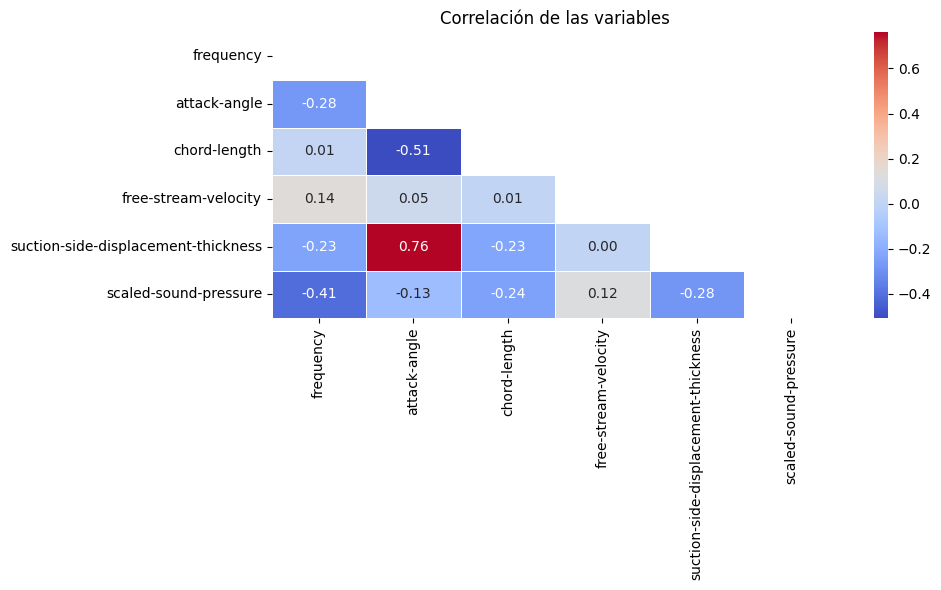

In [3]:
#| label: fig-air_corr
#| fig-cap: Correlación de las variables
#| include: True

corr_calc(air_df_train)

In [4]:
#| label: air_drop_vars
# dropping attack-angle

air_X_train.drop(columns='attack-angle', inplace=True)
air_X_test.drop(columns='attack-angle', inplace=True)

In [5]:
air_lr_best, air_dt_best, air_rf_best, air_gbm_best = init_models(air_X_train, air_y_train)

Linear Regression model fitted
Decision Tree model fitted


/Users/mcargnel/Documents/mem/venv_mem/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest model fitted
Gradient Boosting model fitted


Habiendo entrenado los modelos con los hiperparámetros definidos en la introducción. Se puede ver en la @tbl-air_predictions los resultados en la muestra de testeo. En particular se destaca que _Gradient Boosting_ tiene un menor error en todas las métricas. Por otra parte, la regresión lineal tiene el peor ajuste, esto último se repite con los tres conjuntos de datos que se probaron y va en línea con que los modelos más complejos tienden a tener una mejor performance predictiva.

In [6]:
#| label: tbl-air_predictions
#| tbl-cap: Predicciones de los modelos
#| include: True

evaluate_models(air_y_test, air_dt_best, air_rf_best, air_gbm_best, air_lr_best, air_X_test)

Model,RMSE,MAE,R²
Linear Regression,4.976600,3.917400,0.505600
Decision Tree,2.270800,1.713100,0.897100
Random Forest,1.825800,1.317700,0.933500
Gradient Boosting,1.476100,1.033700,0.956500


A continuación, se procede a utilizar _Permutation Feature Importnace_ y _Partial Dependence Plots_ para entender cómo el modelo de _Gradient Boosting_ utilizó las variables independientes. Empezando con la @fig-air_permutation_importance se puede ver que 'frequency' y 'suction-side-displacement-thickness' son las variables más importantes, seguidas por 'chord-length' y 'free-stream-velocity'.

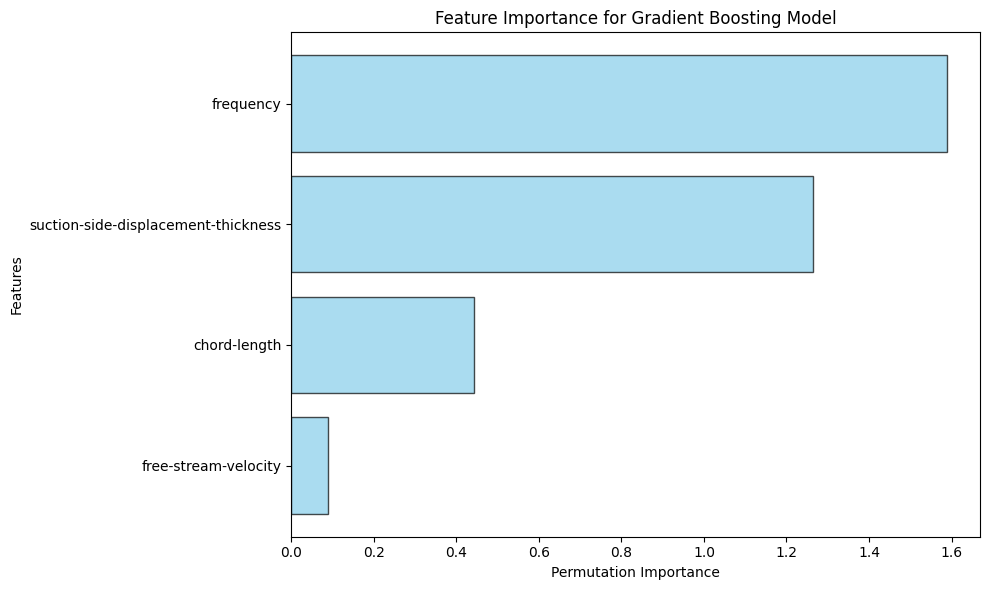

In [7]:
#| label: fig-air_permutation_importance
#| fig-cap: Importancia de las variables para el modelo Gradient Boosting
#| include: True

permutation_importance_plot(air_gbm_best, air_X_test, air_y_test)

Habiendo identificado las variables más importantes, el próximo paso sería entender cómo estas influyen en la variable de respuesta. Es decir como distintos cambios en la 'frequency' (Hz) y 'suction-side-displacement-thickness' (m). Para ello, se puede ver en la @fig-air_partial_dependence los ICE (lineas celeste claro)y PDP (linea punteada) de dichas variables, junto con la cantidad de observaciones (líneas verticales en el eje X)
La frecuencia exhibe una relación descendente con el nivel de presión sonora. En el rango de frecuencias estudiado (0-20000 Hz), se observan las siguientes características: La región de mayor influencia se encuentra en las frecuencias bajas (0-2500 Hz), donde el nivel de presión sonora alcanza sus valores máximos, aproximadamente 130-140 dB. A medida que la frecuencia aumenta, se evidencia una disminución gradual hasta alcanzar niveles de 100-110 dB a 20000 Hz.
El análisis centrado revela que las frecuencias bajas contribuyen positivamente con una desviación de hasta +20 dB respecto a la media, mientras que las frecuencias altas tienen un efecto negativo de magnitud similar (-20 dB).
Sin embargo, cabe destacar que prácticamente no hay observaciones por encima de 7500 de frecuencia. Por lo que las observaciones en estos niveles deberían tomarse con cautela.

Por otro lado, la relación entre el espesor de desplazamiento y el nivel de presión sonora presenta un comportamiento más complejo, los niveles de presión sonora se mantienen predominantemente en el rango de 120-130 dB. La respuesta muestra una naturaleza no lineal con múltiples discontinuidades. El análisis centrado indica fluctuaciones de ±10 dB respecto al valor medio. Se observa una tendencia general levemente descendente, aunque menos pronunciada que en el caso de la frecuencia. Sin embargo, casi todas las observaciones se encuentran por debajo de 0.015.

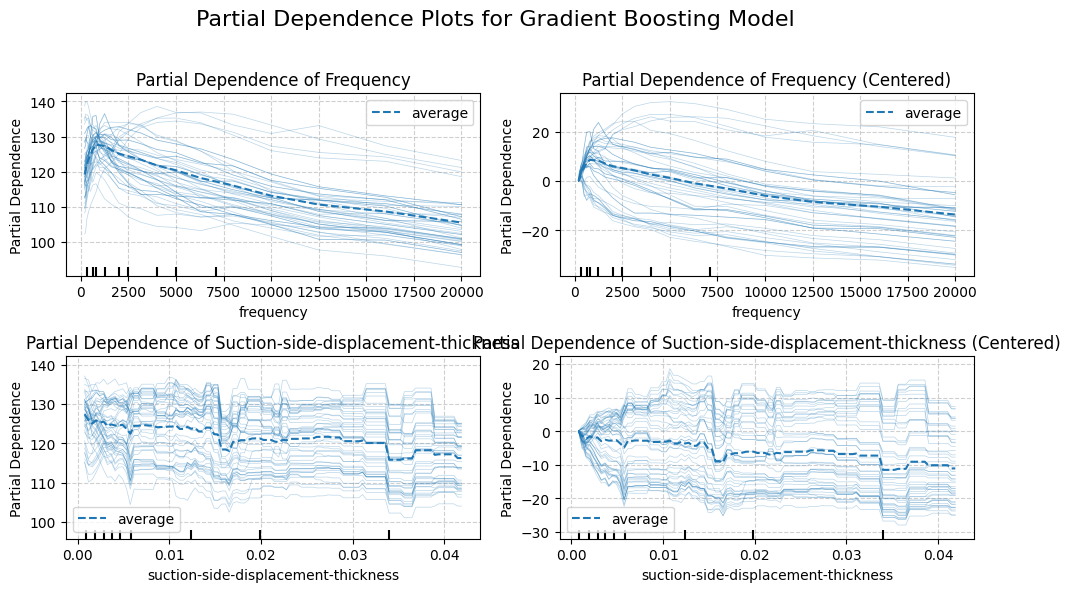

In [8]:
#| label: fig-air_partial_dependence
#| fig-cap: Dependencia parcial de las variables Frequency y Suction-side-displacement-thickness
#| include: True

partial_dependence_plot(air_gbm_best, air_X_test, ['frequency', 'suction-side-displacement-thickness'], ['Frequency', 'Suction-side-displacement-thickness'])

## Concrete Compressive Strength

A continuación se realiza el mismo análisis para el conjunto de datos _Concrete Compressive Strength_ [@concrete_compressive_strength_165] que cuenta con 1030 observaciones distribuidas entre 9 variables. A continuación pueden verse todas las variables incluidas:
 
| Variable | Descripción |
|----------|-------------|
| Cement | Cantidad de cemento en la mezcla (kg/m³) |
| Blast Furnace Slag | Cantidad de escoria de alto horno (kg/m³) |
| Fly Ash | Cantidad de cenizas volantes (kg/m³) |
| Water | Cantidad de agua en la mezcla (kg/m³) |
| Superplasticizer | Cantidad de superplastificante (kg/m³) |
| Coarse Aggregate | Cantidad de agregado grueso (kg/m³) |
| Fine Aggregate | Cantidad de agregado fino (kg/m³) |
| Age | Edad del concreto en días |
| Concrete compressive strength | Resistencia a la compresión del concreto (variable dependiente) |

La variable dependiente será la fuerza del concreto y se utilizarán todas las demás para predecirla.

In [12]:
#| label: concrete_data
concrete_X_train, concrete_X_test, concrete_y_train, concrete_y_test, concrete_df_train, concrete_df_test = fetch_split_ucirepo(165, "Concrete compressive strength")

En la @fig-concrete_corr se puede ver la correlación entre las variables, no se ven correlaciones por encima de 0.8 en valor absoluto por lo que se definió mantener todas las variables en el modelo.

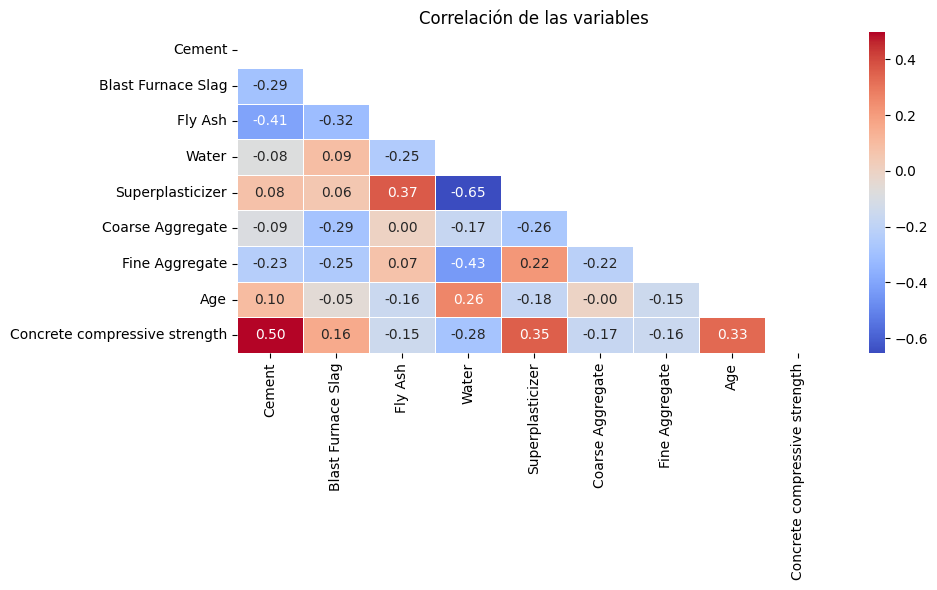

In [16]:
#| label: fig-concrete_corr
#| fig-cap: Correlación de las variables
#| include: True

corr_calc(concrete_df_train)

In [11]:
concrete_lr_model, concrete_dt_best, concrete_rf_best, concrete_gbm_best = init_models(concrete_X_train, concrete_y_train)

Linear Regression model fitted
Decision Tree model fitted
Random Forest model fitted
Gradient Boosting model fitted


En la @tbl-concrete_predictions se pueden ver las predicciones de los modelos. Nuevamente, se ve que el modelos con mejor ajuste en la muestra de testeo es _Gradient Boosting_. A su vez puede verse que la regresión lineal es el que presenta las peores métricas. 

In [12]:
#| label: tbl-concrete_predictions
#| tbl-cap: Predicciones de los modelos
#| include: True

evaluate_models(concrete_y_test, concrete_dt_best, concrete_rf_best, concrete_gbm_best, concrete_lr_model, concrete_X_test)

Model,RMSE,MAE,R²
Linear Regression,9.796500,7.745600,0.627600
Decision Tree,7.067500,4.836400,0.806200
Random Forest,5.519600,3.795700,0.881800
Gradient Boosting,4.350000,2.862900,0.926600


En la @fig-concrete_permutation_importance puede verse la importancia de las variables del modelo _Gradient Boosting_, en particular se destaca la edad y la cantidad de cemento en la muestra como variables más importantes. Por lo que a continuación en la @fig-concrete_partial_dependence se pueden ver los PDPs y ICE de la edad y la cantidad de cemento en la muestra. Para la edad se observa una tendencia creciente pronunciada en los primeros 50 días, donde el efecto sobre la variable dependiente aumenta rápidamente. Después de los 50 días, la curva se estabiliza, mostrando un crecimiento más gradual y menos pronunciado.
La relación con el cemento muestra un patrón escalonado, con varios puntos de inflexión claros. Se observan incrementos significativos en ciertos rangos específicos (alrededor de 250, 300 y 350 unidades). Es importante destacar que, para ambas variables, las líneas se ven mayormente paralelas. Esto último indica que dichas variables podrían ser bastante independientes de las demaás.

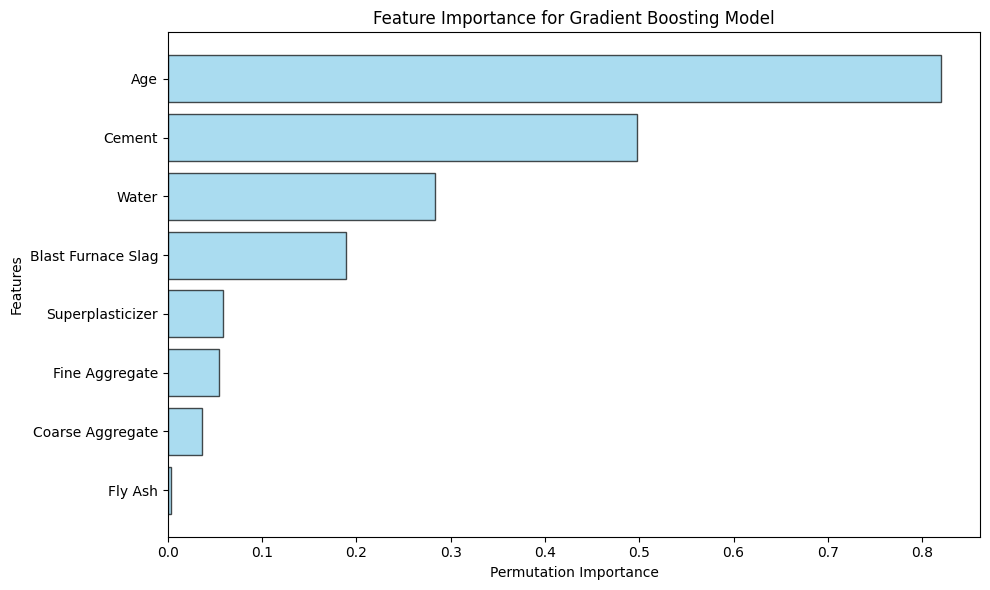

In [13]:
#| label: fig-concrete_permutation_importance
#| fig-cap: Importancia de las variables para el modelo Gradient Boosting
#| include: True

permutation_importance_plot(concrete_gbm_best, concrete_X_test, concrete_y_test)

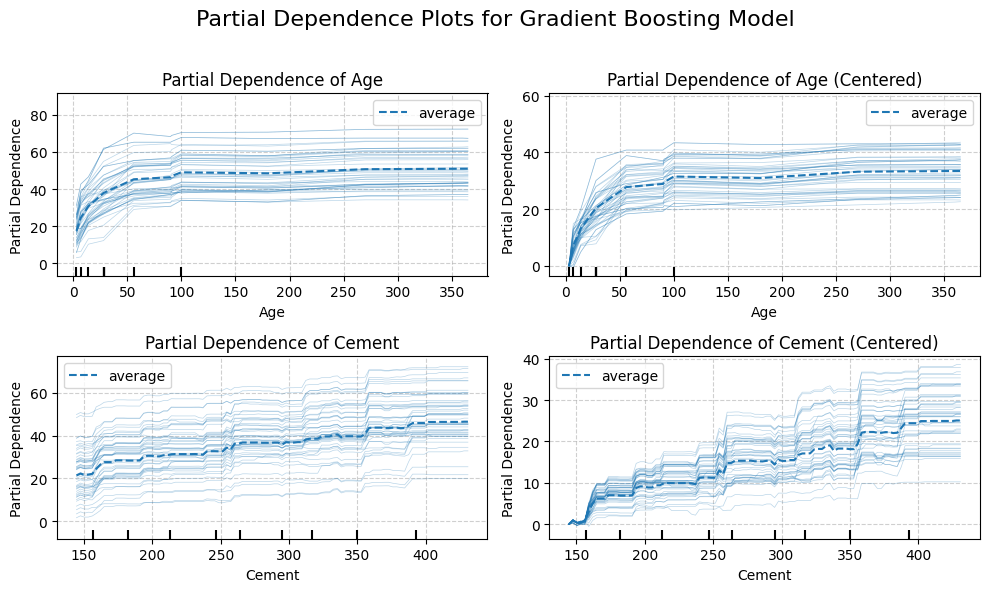

In [14]:
#| label: fig-concrete_partial_dependence
#| fig-cap: Dependencia parcial de las variables Age y Cement
#| include: True

partial_dependence_plot(concrete_gbm_best, concrete_X_test, ['Age', 'Cement'], ['Age', 'Cement'])

## Wine Quality

Estos datos son los resultados de un análisis químico de vinos cultivados en la misma región de Italia pero derivados de tres variedades diferentes. El análisis determinó las cantidades de 13 componentes encontrados en cada uno de los tres tipos de vinos. El conjunto de datos se obtuvo de [@wine_109] y contiene 4898 observaciones.A continuación se presenta una tabla con las variables del conjunto de datos y su significado:
 
| Variable | Significado |
|----------|-------------|
| fixed_acidity | Acidez fija en el vino (principalmente ácido tartárico) |
| volatile_acidity | Acidez volátil en el vino (principalmente ácido acético) |
| citric_acid | Ácido cítrico presente en el vino |
| residual_sugar | Cantidad de azúcar residual en el vino |
| chlorides | Contenido de cloruros (sal) en el vino |
| free_sulfur_dioxide | Dióxido de azufre libre en el vino (conservante) |
| total_sulfur_dioxide | Dióxido de azufre total en el vino (libre + combinado) |
| density | Densidad del vino |
| pH | Nivel de acidez/alcalinidad del vino (escala pH) |
| sulphates | Contenido de sulfatos en el vino |
| alcohol | Contenido de alcohol en el vino (% por volumen) |
| quality | Calidad del vino (puntuación entre 0 y 10) |


In [5]:
#| label: wine_data
wine_X_train, wine_X_test, wine_y_train, wine_y_test, wine_df_train, wine_df_test = fetch_split_ucirepo(186, "quality")

En la @fig-wine_corr puede verse la correlación entre las variables del conjunto de datos. En particular, se detaca la alta correlación entre 'total-sulfur-dioxide' y 'free-sulfur-dioxide', por lo que se decidió eliminar la segunda.

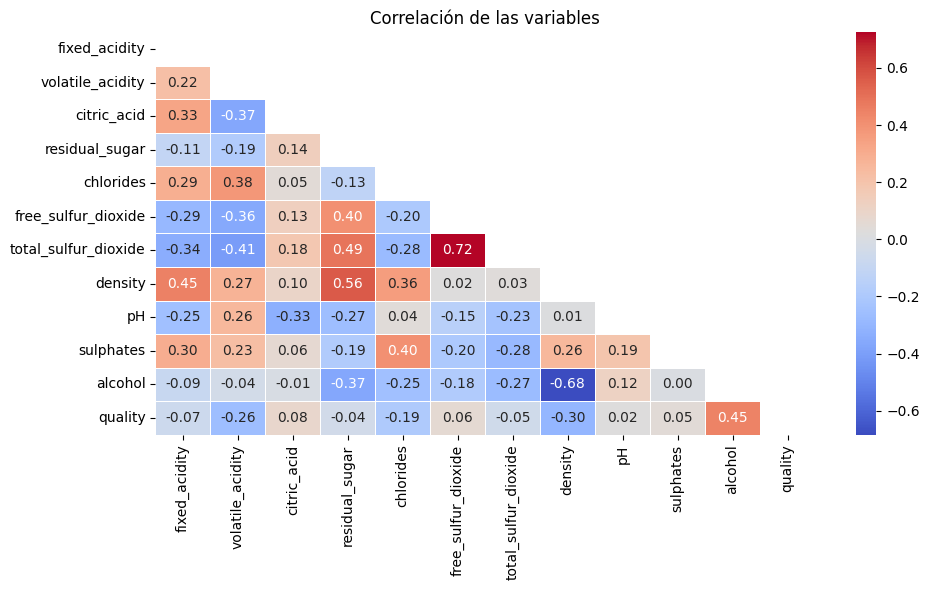

In [10]:
#| label: fig-wine_corr
#| fig-cap: Correlación de las variables
#| include: True

corr_calc(wine_df_train)

In [17]:
wine_X_train.drop(columns='free_sulfur_dioxide', inplace=True)
wine_X_test.drop(columns='free_sulfur_dioxide', inplace=True)

In [19]:
#| label: wine_init_models

wine_lr_model, wine_dt_best, wine_rf_best, wine_gbm_best = init_models(wine_X_train, wine_y_train)

Linear Regression model fitted
Decision Tree model fitted
Random Forest model fitted
Gradient Boosting model fitted


En la @tbl-wine_predictions pueden verse los resultados de los modelos en la muestra de testeo. En particular, se destaca que _Random Forest_ tuvo la mejor performance predictiva, inclusive superando a _Gradient Boosting_ que había sido el que tuvo mejores resultados en los otros dos conjuntos de datos.

In [20]:
#| label: tbl-wine_predictions
#| tbl-cap: Predicciones de los modelos
#| include: True

evaluate_models(wine_y_test, wine_dt_best, wine_rf_best, wine_gbm_best, wine_lr_model, wine_X_test)

Model,RMSE,MAE,R²
Linear Regression,0.737800,0.568400,0.263000
Decision Tree,0.769700,0.586900,0.197900
Random Forest,0.610300,0.437900,0.495700
Gradient Boosting,0.648300,0.481800,0.430800


En la @fig-wine_permutation_importance puede verse la importancia de todas las variables independientes incluidas en el modelo de _Random Forest_. En particular, se destacan el alcohol y la acidez volátil del vino como las variables más importantes. En la @fig-wine_partial_dependence pueden verse los PDP y ICE de las dos variables más importantes. Para el alcohol se observa una relación positiva general entre el contenido de alcohol y la calidad del vino, la tendencia es creciente pero no lineal, con varios puntos de inflexión notables: Un primer incremento suave entre 9% y 11% de alcohol, un salto más pronunciado alrededor del 12% de alcohol y una estabilización después del 13% de alcohol. Por lo que el efecto es más pronunciado en el rango medio (11-13%). Las líneas individuales muestran un patrón bastante paralelo, sugiriendo pocas interacciones con otras variables. 

Para la acidez volátil: Muestra una relación negativa con la variable objetivo siendo la tendencia es ligeramente decreciente y relativamente lineal. Por otra parte, el efecto es más suave y menos pronunciado que el del alcohol observándose: Una pendiente negativa consistente a lo largo del rango, mayor variabilidad en las predicciones individuales (líneas azules claras más dispersas)
y que el efecto negativo se hace más pronunciado en valores más altos de acidez volátil

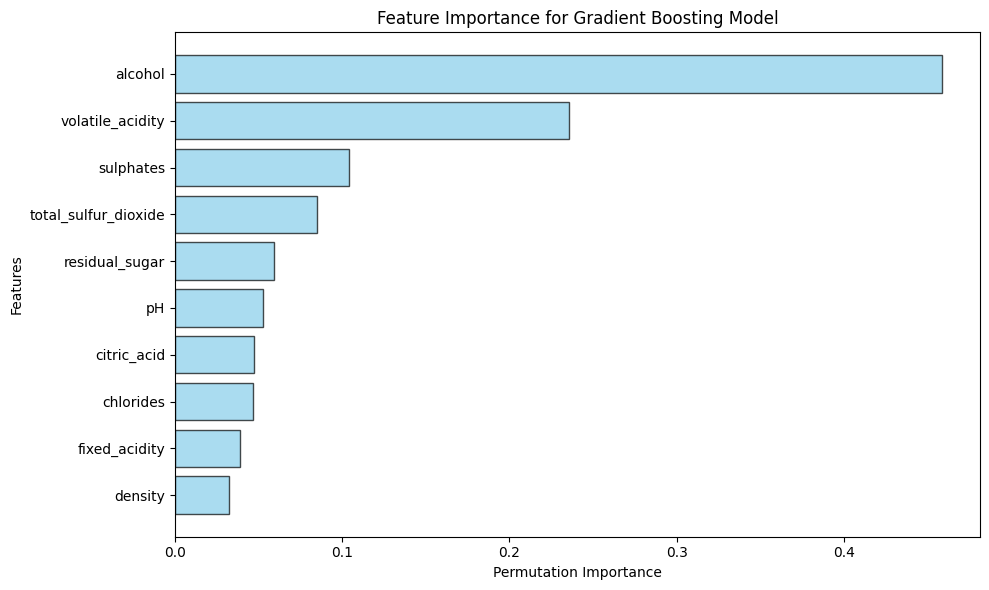

In [21]:
#| label: fig-wine_permutation_importance
#| fig-cap: Importancia de las variables para el modelo Gradient Boosting
#| include: True

permutation_importance_plot(wine_rf_best, wine_X_test, wine_y_test)

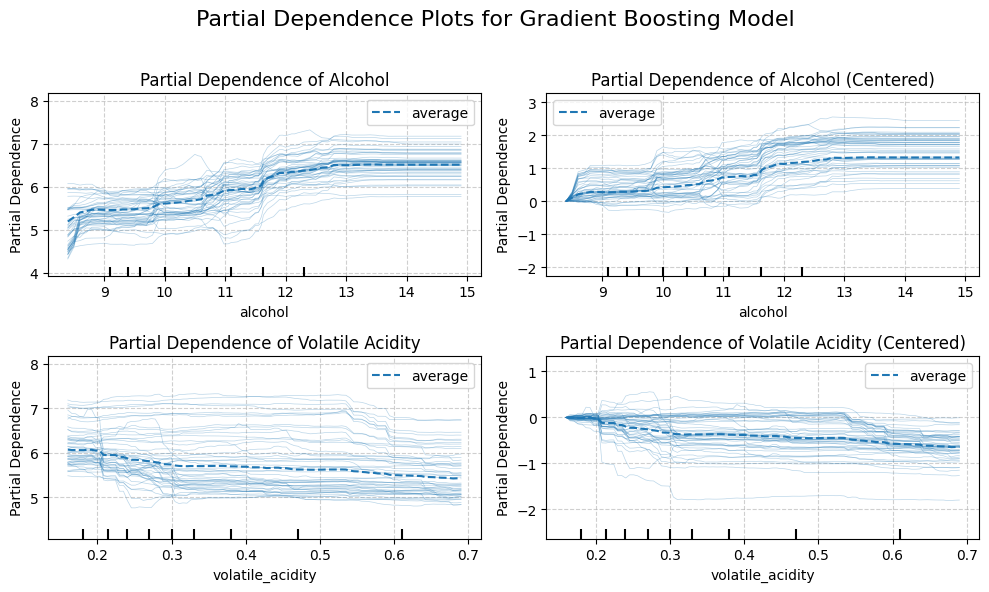

In [23]:
#| label: fig-wine_partial_dependence
#| fig-cap: Dependencia parcial de las variables Age y Cement
#| include: True

partial_dependence_plot(wine_rf_best, wine_X_test, ['alcohol', 'volatile_acidity'], ['Alcohol', 'Volatile Acidity'])